✅ Found ┊ model=rtma ┊ product=pcp ┊ 2023-Feb-22 06:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws


/opt/anaconda3/lib/python3.12/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


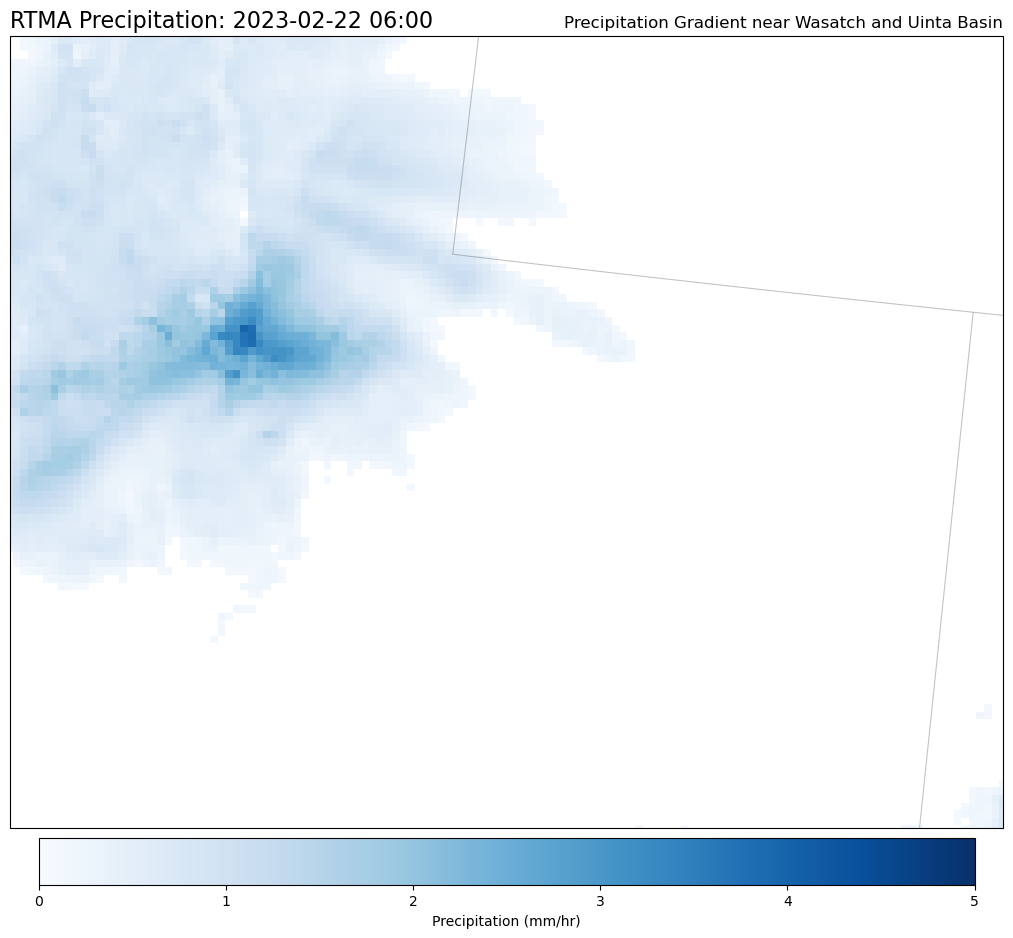

In [34]:
from herbie import Herbie
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from herbie.toolbox import EasyMap, pc

# Set your analysis date/time
date = "2023-02-22 06:00"

# Download RTMA precipitation data
H = Herbie(date, model="rtma", product="pcp")

# First download the data
H.download()

# Then load with xarray using the appropriate engine
ds = H.xarray(engine='cfgrib', backend_kwargs={'decode_timedelta': False})
# No need for ds = datasets[0] since ds is already the dataset

# Mask zero or very low precipitation values for clarity
ds['tp'] = ds.tp.where(ds.tp > 0.1)

# Set up map with Cartopy
fig = plt.figure(figsize=(12, 10))
ax = EasyMap('50m', crs=ds.herbie.crs, figsize=[12, 10]).STATES().ax

# Plot precipitation
precip = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.tp,
    cmap="Blues",
    transform=pc,
    shading='auto',
    vmin=0,
    vmax=5  # Adjust this upper limit based on expected values
)

# Colorbar
cb = plt.colorbar(precip, ax=ax, orientation='horizontal', pad=0.01, shrink=0.8)
cb.set_label('Precipitation (mm/hr)')

# Zoom in to Uinta Basin and Wasatch Range region
ax.set_extent([-112.5, -109, 39.5, 41.5], crs=ccrs.PlateCarree())

# Add titles
ax.set_title(f"RTMA Precipitation: {date}", fontsize=16, loc='left')
ax.set_title("Precipitation Gradient near Wasatch and Uinta Basin", fontsize=12, loc='right')

# Show the plot
plt.tight_layout()
plt.show()


### Added plotting features to the map

✅ Found ┊ model=rtma ┊ product=pcp ┊ 2023-Feb-22 08:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws


/opt/anaconda3/lib/python3.12/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


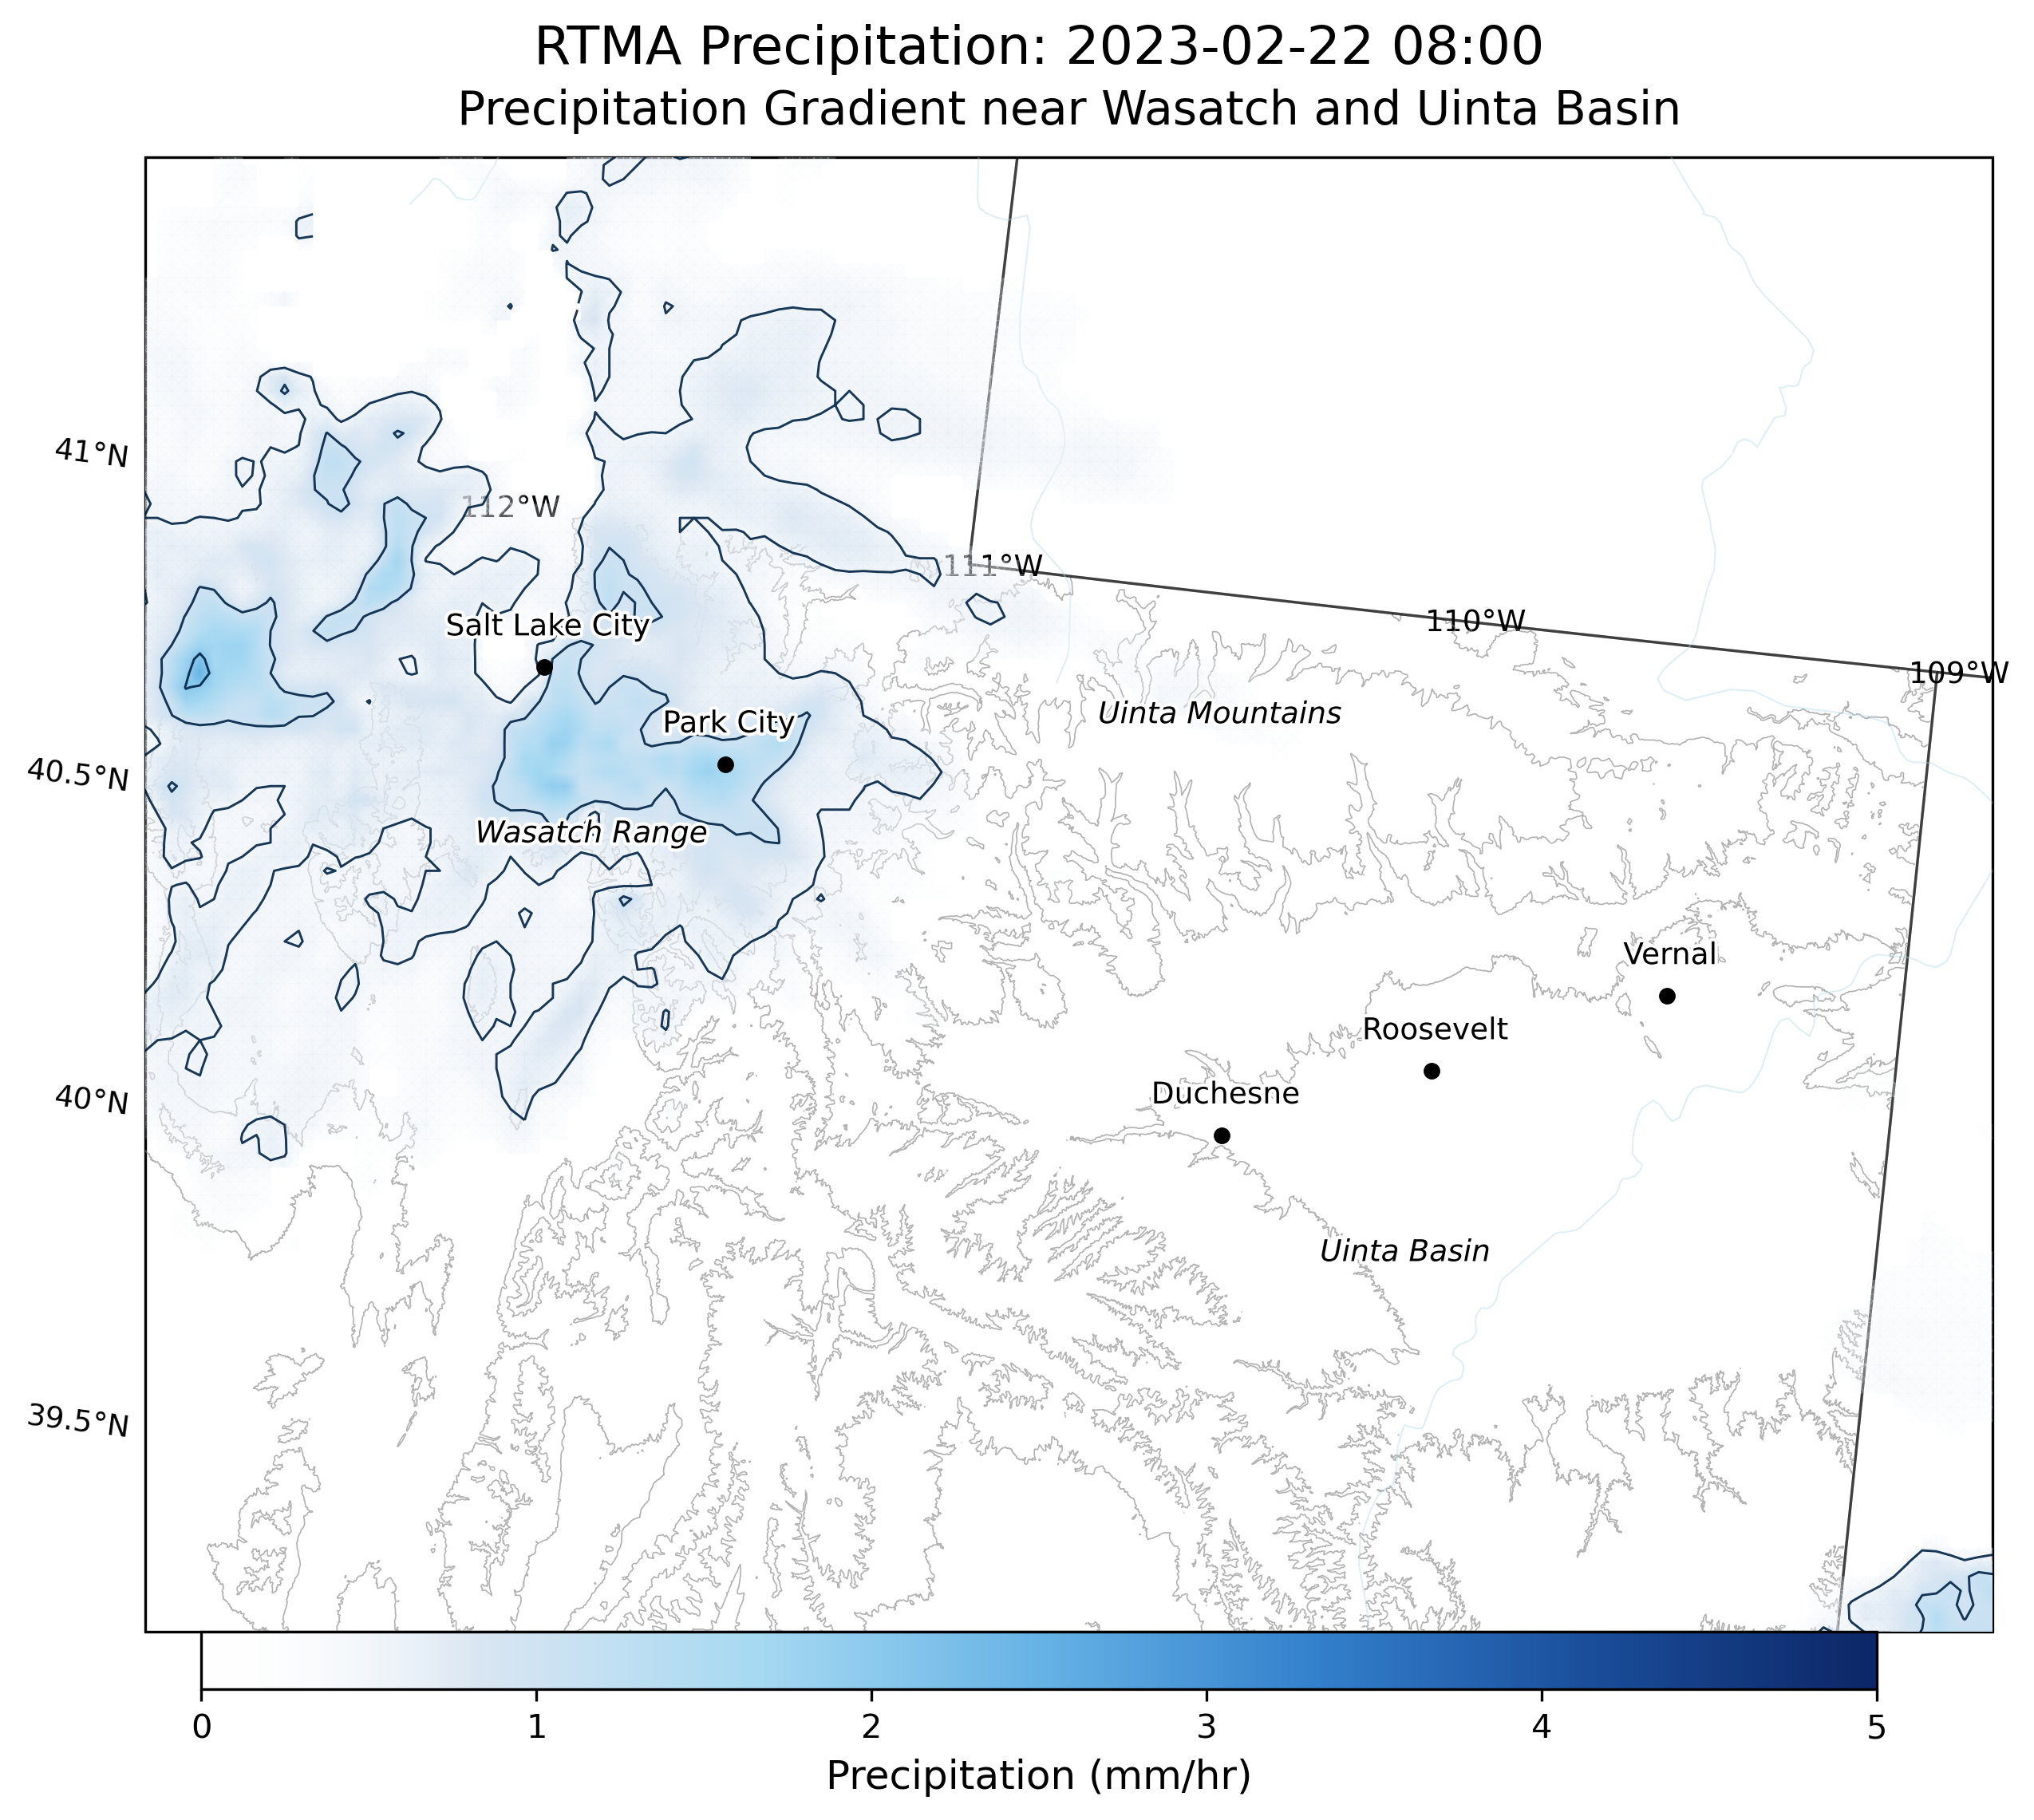

In [17]:
from herbie import Herbie
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from herbie.toolbox import EasyMap, pc
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as PathEffects
import rasterio
import scipy.ndimage as ndimage
import numpy.ma as ma

# Set your analysis date/time
date = "2023-02-22 08:00"

# Download RTMA precipitation data
H = Herbie(date, model="rtma", product="pcp")
H.download()

# Load with xarray using the appropriate engine
ds = H.xarray(engine='cfgrib', backend_kwargs={'decode_timedelta': False})

# Mask zero or very low precipitation values for clarity
ds['tp'] = ds.tp.where(ds.tp > 0.1)

# Create a custom colormap for precipitation
colors = [(1, 1, 1, 0),          # transparent for no precipitation
          (0.85, 0.9, 0.95, 1),  # very light blue
          (0.65, 0.85, 0.95, 1), # light blue
          (0.4, 0.7, 0.9, 1),    # medium blue
          (0.2, 0.5, 0.8, 1),    # blue
          (0.1, 0.3, 0.6, 1),    # dark blue
          (0.05, 0.15, 0.4, 1)]  # very dark blue
precip_cmap = LinearSegmentedColormap.from_list('precipitation', colors, N=256)

# Set up figure with higher DPI for publication quality
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 8), dpi=300)

# Create the map with the same projection as the RTMA data
ax = plt.axes(projection=ds.herbie.crs)

# Set the map extent to focus on the study area
ax.set_extent([-112.5, -109, 39.5, 41.5], crs=ccrs.PlateCarree())

# Path to your DEM file
dem_file = '/Users/a02428741/PycharmProjects/snowshadow/notebooks/uinta_dem_data/merged_dem.tif'

# Open the DEM file using rasterio
with rasterio.open(dem_file) as src:
    # Read the first band of the DEM
    dem = src.read(1)

    # Get the transformation information to convert array indices to coordinates
    transform = src.transform

    # Create a regular grid of coordinates in the DEM's projection
    height, width = dem.shape
    rows, cols = np.mgrid[0:height, 0:width]

    # Convert grid indices to coordinates using the transform
    xs, ys = rasterio.transform.xy(transform, rows.flatten(), cols.flatten())

    # Reshape back to 2D arrays matching the DEM shape
    xs = np.array(xs).reshape(rows.shape)
    ys = np.array(ys).reshape(cols.shape)

    # Get arrays of unique x and y coordinates
    x_coords = xs[0, :]  # First row contains all x coordinates
    y_coords = ys[:, 0]  # First column contains all y coordinates

    # Create a longitude mask to remove data that spills into Colorado
    # Utah-Colorado border is approximately at -109.05 degrees longitude
    lon_mask = xs < -109.05

    # Smooth the DEM to reduce noise and make contours more appealing
    dem_smoothed = ndimage.gaussian_filter(dem, sigma=2)

    # Apply the mask to remove Colorado data
    dem_masked = ma.masked_array(dem_smoothed, mask=~lon_mask)

    # Convert elevation from meters to feet (standard for US)
    dem_feet = dem_masked * 3.28084

# Add elevation contours with darker lines and no labels, using the masked data
contour_levels = np.arange(6000, 11000, 2000)  # 2000 ft intervals
contours = ax.contour(
    x_coords,
    y_coords,
    dem_feet,
    levels=contour_levels,
    colors='gray',       # Darker gray for contour lines
    linewidths=0.4,
    alpha=0.6,           # Increased alpha for better visibility
    transform=ccrs.PlateCarree(),
    zorder=5
)

# Add state boundaries (subtle)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.8, edgecolor='black', alpha=0.5, zorder=10)

# Keep rivers but with reduced visibility
ax.add_feature(cfeature.RIVERS.with_scale('10m'), linewidth=0.5, edgecolor='lightblue', alpha=0.4, zorder=15)

# Plot precipitation with improved colormap and smooth shading
precip = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.tp,
    cmap=precip_cmap,
    transform=pc,
    shading='gouraud',
    vmin=0,
    vmax=5,
    zorder=20
)

# Restore original precipitation contours with darker lines
precip_contour_levels = [0.5, 1, 2, 3, 4]  # Original contour levels
precip_contours = ax.contour(
    ds.longitude,
    ds.latitude,
    ds.tp,
    levels=precip_contour_levels,
    colors=['#002244'],  # Darker blue for better visibility
    linewidths=0.7,      # Slightly thicker
    alpha=0.9,           # More opaque
    transform=pc,
    zorder=25
)

# Add major cities for reference
cities = {
    'Salt Lake City': (-111.891, 40.761),
    'Park City': (-111.498, 40.646),
    'Vernal': (-109.528, 40.455),
    'Roosevelt': (-109.989, 40.299),
    'Duchesne': (-110.400, 40.163)
}

# Add each city as a point with a label
for city, (lon, lat) in cities.items():
    # Add city marker
    ax.plot(lon, lat, 'ko', markersize=4, transform=pc, zorder=30)

    # Add city label with white outline for visibility
    txt = ax.text(lon, lat+0.05, city, fontsize=9, ha='center', transform=pc, zorder=30)
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])

# Add geographic labels
geographic_labels = [
    ("Wasatch Range", -111.75, 40.5),
    ("Uinta Mountains", -110.5, 40.8),
    ("Uinta Basin", -110.0, 40.0)
]

# Add each geographic label with styling
for name, lon, lat in geographic_labels:
    txt = ax.text(lon, lat, name, fontsize=9,
                 fontstyle='italic', ha='center',
                 transform=pc, zorder=35,
                 path_effects=[PathEffects.withStroke(linewidth=2, foreground='white')])

# Simplify grid - only labels, no gridlines
gl = ax.gridlines(crs=pc, draw_labels=True, linewidth=0.0, alpha=0.0)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'black'}
gl.ylabel_style = {'size': 9, 'color': 'black'}

# Add colorbar
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.03])  # [left, bottom, width, height]
cb = plt.colorbar(precip, cax=cbar_ax, orientation='horizontal')
cb.set_label('Precipitation (mm/hr)', fontsize=12)
cb.ax.tick_params(labelsize=10)

# Add titles
plt.suptitle(f"RTMA Precipitation: {date}", fontsize=16, y=0.95)
ax.set_title("Precipitation Gradient near Wasatch and Uinta Basin", fontsize=14, pad=10)

plt.savefig('rtma_precipitation_map_utah_only.png', dpi=300, bbox_inches='tight')
plt.savefig('rtma_precipitation_map_utah_only.pdf', bbox_inches='tight')  # Vector format

plt.show()